In [1]:
# !pip install cupy-cuda100 -user

In [2]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import tqdm
%config Completer.use_jedi=False

# [High performance with <u><i><strong>CUDA</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u> is an open-source matrix library accelerated with <u><i><strong>NVIDIA CUDA</strong></i></u>. <u><i><strong>CuPy</strong></i></u> provides GPU accelerated computing with Python. CuPy uses CUDA-related libraries including <u><i><strong>cuBLAS</strong></i></u>, <u><i><strong>cuDNN</strong></i></u>, <u><i><strong>cuRand</strong></i></u>, <u><i><strong>cuSolver</strong></i></u>, <u><i><strong>cuSPARSE</strong></i></u>, <u><i><strong>cuFFT</strong></i></u> and <u><i><strong>NCCL</strong></i></u> to make full use of the <u><i><strong>GPU</strong></i></u> architecture.
The figure shows <u><i><strong>CuPy</strong></i></u> speedup over NumPy. Most of them perform well on a <u><i><strong>GPU</strong></i></u> using CuPy out of the box. <u><i><strong>CuPy</strong></i></u> speeds up some operations more than 100X. You can read original benchmark article in [Single-<u><i><strong>GPU</strong></i></u> <u><i><strong>CuPy</strong></i></u> Speedups (RAPIDS AI)](https://medium.com/rapids-ai/single-gpu-cupy-speedups-ea99cbbb0cbb).

![CuPy speedup over NumPy](CuPy_Performance.png)

# [Highly compatible with <u><i><strong>NumPy</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u>'s interface is highly compatible with <u><i><strong>NumPy</strong></i></u>; in most cases it can be used as a <strong><i><u>drop-in replacement</u></i></strong>. <i><u>All you need to do</u></i> is just <strong><i><u>replace numpy with cupy</u></i></strong> in your Python code. [Basics of <u><i><strong>CuPy</strong></i></u> (Tutorial)](https://docs-cupy.chainer.org/en/stable/tutorial/basic.html) is usefull to learn first step of <u><i><strong>CuPy</strong></i></u>.
<u><i><strong>CuPy</strong></i></u> supports various methods, indexing, data types, broadcasting and more. [Comparison Table (Reference Manual)](https://docs-cupy.chainer.org/en/stable/reference/comparison.html) shows a list of NumPy / <u><i><strong>SciPy</strong></i></u> APIs and its corresponding <u><i><strong>CuPy</strong></i></u> implementations.

In [3]:
x = cp.arange(6).reshape(2, 3).astype('f')
print("x =\n", x)

sum_result = x.sum(axis=1)
print("\nsum = ",sum_result)

x =
 [[0. 1. 2.]
 [3. 4. 5.]]

sum =  [ 3. 12.]


# [Easy to write a custom kernel](https://cupy.chainer.org/)
You can easily make a custom <u><i><strong>CUDA</strong></i></u> kernel if you want to make your code run faster, requiring only a small code snippet of <u><i><strong>C++</strong></i></u>. <u><i><strong>CuPy</strong></i></u> automatically wraps and compiles it to make a <u><i><strong>CUDA</strong></i></u> binary. Compiled binaries are cached and reused in subsequent runs. Please read [User-Defined Kernels (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html).
And, you can also use raw <u><i><strong>CUDA</strong></i></u> kernel via [Raw modules (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html#raw-modules).


In [4]:
x=cp.arange(6, dtype='f').reshape(2, 3)
y=cp.arange(3, dtype='f')
kernel=cp.ElementwiseKernel(
    'float32 x,float32 y','float32 z',
        '''if(x-2>y){
        z=x*y;
        }else{
        z=x+y;
        }''',
    'my_kernel')

print("Input x = \n", x)
print("\nInput y = \n", y)

result = kernel(x, y)

print("\nresult of the kernel =\n", result)

Input x = 
 [[0. 1. 2.]
 [3. 4. 5.]]

Input y = 
 [0. 1. 2.]

result of the kernel =
 [[ 0.  2.  4.]
 [ 0.  4. 10.]]


## Task 10. Saxpy

By using <u><i><strong>CuPy</strong></i></u>, implement SAXPY function. The function is described in the picture.

![saxpy](saxpy.jpg)

In [5]:
# Cupy uses GPU to perform computation. How is transfer is handled?

In [6]:
def np_saxpy(x, y, a):
    return x*a + y

@cp.fuse()
def cp_saxpy(x, y, a):
    return x*a + y

In [7]:
np_res = []
for s in tqdm.tqdm_notebook(np.logspace(2, 4, 20)):
    s = int(s)
    np_x, np_y, np_a = np.random.rand(s,s).astype(np.float32), np.random.rand(s,s).astype(np.float32), np.float32(4.5)
    t = %timeit -o -q np_saxpy(np_x, np_y, np_a);
    np_res.append(t)

In [8]:
cp_res = []
for s in tqdm.tqdm_notebook(np.logspace(2, 4, 20)):
    s = int(s)
    cp_x, cp_y, cp_a = cp.random.rand(s,s,dtype='f'), cp.random.rand(s,s, dtype='f'), cp.float32(4.5)
    t = %timeit -q -o cp_saxpy(cp_x, cp_y, cp_a);
    cp_res.append(t)

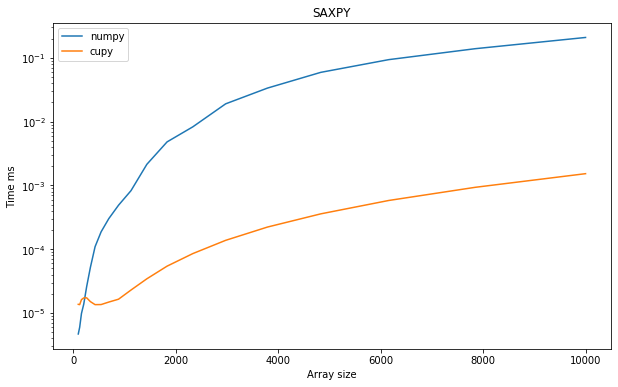

In [9]:
plt.figure(figsize=(10,6))
plt.plot(np.logspace(2, 4, 20), [i.average for i in np_res])
plt.plot(np.logspace(2, 4, 20), [i.average for i in cp_res])
plt.title('SAXPY')
plt.yscale('log')
plt.xlabel('Array size')
plt.ylabel('Time ms')
plt.legend(['numpy', 'cupy']);

## Task 11. CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map (Task 1).

In [10]:
def np_fun(r, x):
    res = r*x*(1-x)
    return res

@cp.fuse()
def cp_fun(r, x):
    res = r*x*(1-x)
    return res

In [11]:
s = int(1e8)
np_r = np.linspace(0, 4, s, dtype='float32')
cp_r = cp.linspace(0, 4, s, dtype='float32')
x = np.random.rand()
cp_x = cp.float32(x)

In [12]:
%timeit np_fun(np_r, x);

176 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit cp_fun(np_r, x);

211 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit cp_fun(cp_r, x);

1.11 ms ± 31.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
s = %prun -r np_fun(np_r, x)
s.print_stats();

          4 function calls in 0.175 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.174    0.174    0.174    0.174 <ipython-input-10-1736a7abcc20>:1(np_fun)
        1    0.001    0.001    0.175    0.175 <string>:1(<module>)
        1    0.000    0.000    0.175    0.175 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [16]:
s = %prun -r cp_fun(cp_r, x)
s.print_stats();

          3 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [17]:
np_res = []
for s in tqdm.tqdm_notebook(np.logspace(2, 7, 20)):
    s = int(s)
    np_r, np_x = np.linspace(0, 4, s).astype(np.float32), np.random.rand(s).astype(np.float32)
    t = %timeit -o -q np_fun(np_r, np_x)
    np_res.append(t)

In [18]:
cp_res = []
for s in tqdm.tqdm_notebook(np.logspace(2, 7, 20)):
    s = int(s)
    cp_r, cp_x = cp.linspace(0, 4, s, dtype='f'), cp.random.rand(s, dtype='f')
    t = %timeit -o -q cp_fun(cp_r, cp_x)
    cp_res.append(t)

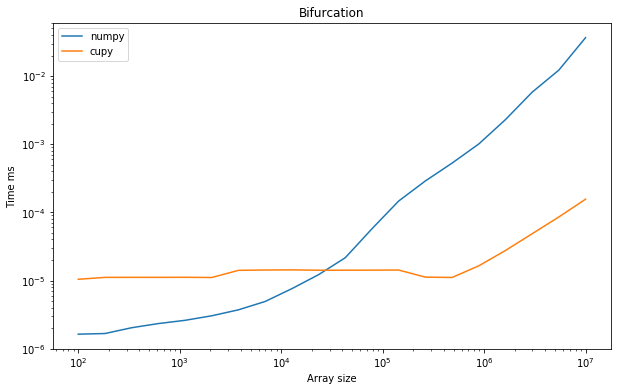

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.logspace(2, 7, 20), [i.best for i in np_res])
plt.plot(np.logspace(2, 7, 20), [i.best for i in cp_res])
plt.title('Bifurcation')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Array size')
plt.ylabel('Time ms')
plt.legend(['numpy', 'cupy']);

## Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

<strong >Hint about function $f(x)$ appearance:</strong>
    ![Hint](Hint.png)

In [20]:
@cp.fuse()
def z(x):
    return cp.sin(3*x) - 0.5

@cp.fuse()
def f(x):
    return (cp.power(z(x),2)+cp.power(z(x),3)-200*cp.power(z(x),4))*cp.sin(1e5*(x+0.5))

x = cp.linspace(0,1, int(1e7))
y = f(x)
f_min = y.min()
f_max = y.max()
delta = 0.1 * (f_max - f_min)
print('Min: {}. Max {}.'.format(f_min, f_max))

Min: -12.365544666168107. Max 12.374912294071224.


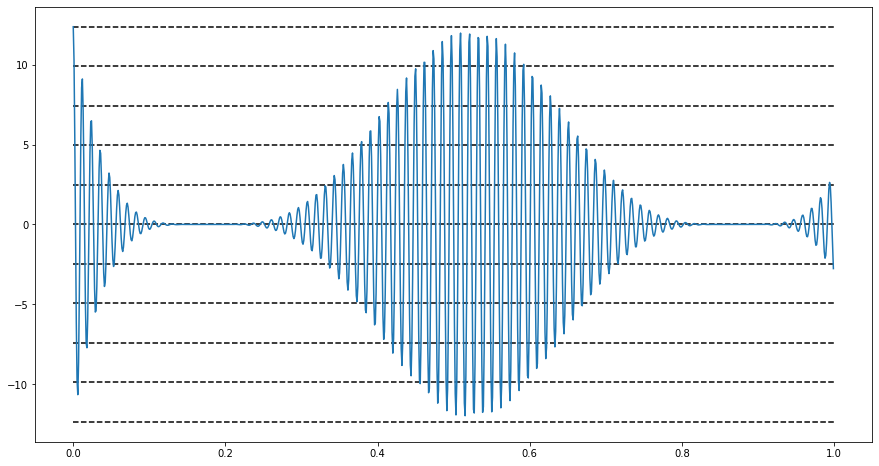

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(x.tolist()[::10000], y.tolist()[::10000]);
plt.hlines([np.float(f_min + i*delta) for i in range(11)], 0, 1, linestyles='dashed')

In [22]:
np_y = cp.asnumpy(y)
%timeit y[y>5]
%timeit np_y[np_y>5]

670 µs ± 56.7 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.1 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


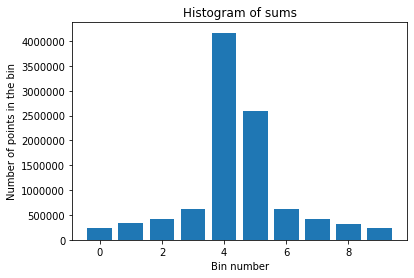

In [23]:
res = []
for i in range(10):
#     cp.logical_and((f_min + (i+1)*delta) > y, y > (f_min + i*delta))
    r = ((f_min + (i+1)*delta) > y) & (y > (f_min + i*delta))
    r = cp.sum(r)
    res.append(cp.asnumpy(r))
res = np.array(res)
plt.bar(np.arange(10),res)
plt.title('Histogram of sums')
plt.xlabel('Bin number')
plt.ylabel('Number of points in the bin');

In [24]:
# select points in the interval
sub_y = ((f_min + delta) > y) & (y > f_min)
np_sub_y = cp.asnumpy(sub_y)

In [25]:
%timeit -n 100 cp.sum(sub_y)

16.8 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit -n 100 np.sum(np_sub_y)

8.8 ms ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Task 13. Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image and 

<strong >Example of a blurred image:</strong>
    ![Blur](blur.jpg)

In [27]:
#!wget -q https://quintagroup.com/cms/python/images/opencv-logo.png/@@images/image.png
from PIL import Image
im_s = 100
pil_img = Image.open('image.png').resize((im_s,im_s)).convert('L')
img = np.array(pil_img)
k_hs = 3
k_s = 2 * k_hs + 1
kernel = np.ones((k_s,k_s))
kernel /= kernel.sum()
cp_img = cp.array(img)
cp_kernel = cp.array(kernel)

In [28]:
big_img = np.empty((im_s*im_s, k_s*k_s), dtype='float32')
for i in range(k_hs, im_s-k_hs):
  for j in range(k_hs, im_s-k_hs):
    big_img[i*im_s + j] = img[i-k_hs:i+k_hs+1, j-k_hs:j+k_hs+1].flatten()

In [29]:
def np_blur_loop(img, kernel):
    res = np.empty_like(img)
    for i in range(k_hs, im_s-k_hs):
        for j in range(k_hs, im_s-k_hs):
          res[i, j] = (img[i-k_hs:i+k_hs+1, j-k_hs:j+k_hs+1] * kernel).sum()

def np_blur(big_img, kernel):
  f_kernel = np.ravel(kernel)
  res = np.dot(big_img, f_kernel)
  return np.reshape(res, (im_s, im_s))

np_res = np_blur(big_img, kernel)
    

In [30]:
def cp_blur(big_img, kernel):
  f_kernel = cp.ravel(kernel)
  res = cp.dot(big_img, f_kernel)
  return cp.reshape(res, (im_s, im_s))

def cp_blur_loop(img, kernel):
    res = cp.empty_like(img)
    for i in range(k_hs, im_s-k_hs):
        for j in range(k_hs, im_s-k_hs):
          res[i, j] = (img[i-k_hs:i+k_hs+1, j-k_hs:j+k_hs+1] * kernel).sum()
   
cp_big_img = cp.array(big_img)          
cp_res = cp_blur(cp_big_img, cp_kernel)
cp_res = cp.asnumpy(cp_res)

In [31]:
np_blur(big_img, kernel);

In [32]:
%timeit np_blur(big_img, kernel)

1.44 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
cp_blur(cp_big_img, cp_kernel);

In [34]:
%timeit -n 100 cp_blur(cp_big_img, cp_kernel)

88 µs ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
np_blur_loop(img, kernel);
cp_blur_loop(cp_img, cp_kernel);

In [36]:
%timeit np_blur_loop(img, kernel)

36.4 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit cp_blur_loop(cp_img, cp_kernel)

407 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


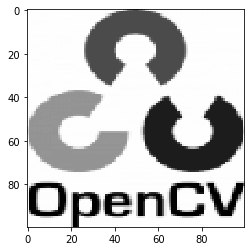

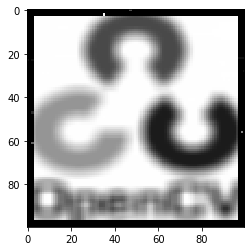

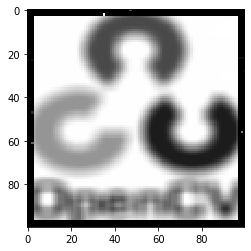

In [38]:
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(np_res.astype(np.uint8), cmap='gray')
plt.show()
plt.imshow(cp_res.astype(np.uint8), cmap='gray');